In [2]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
DATADIR = 'E:\Football Analysis\Source Code\Metrica\data'
game_id = 2

In [4]:
events = mio.read_event_data(DATADIR,game_id)

In [5]:
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [6]:
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

In [7]:
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

In [8]:
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x116effb8>)

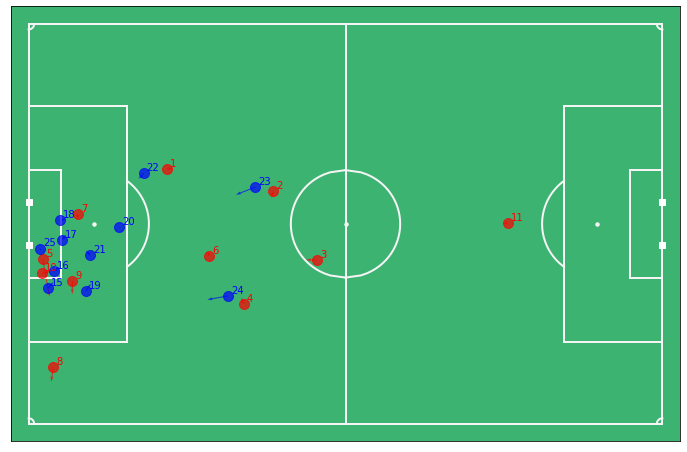

In [9]:
mviz.plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)

In [10]:
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

In [11]:
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

In [12]:
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

Text(0, 0.5, 'Distance covered [km]')

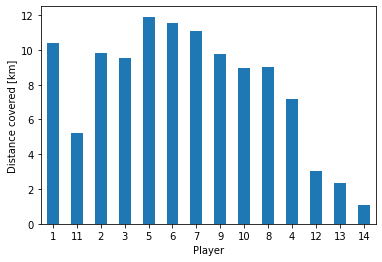

In [13]:
plt.subplots()
ax = home_summary['Distance [km]'].plot.bar(rot=0)
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [km]')

In [14]:
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )

In [15]:
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting

Text(0, 0.5, 'Distance covered [m]')

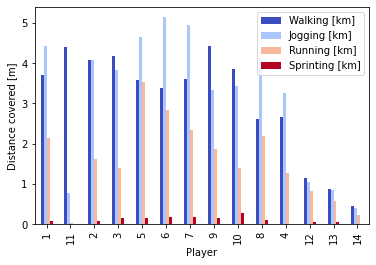

In [16]:
ax = home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]')

In [17]:
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

In [18]:
player = '10'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y'

In [19]:
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1

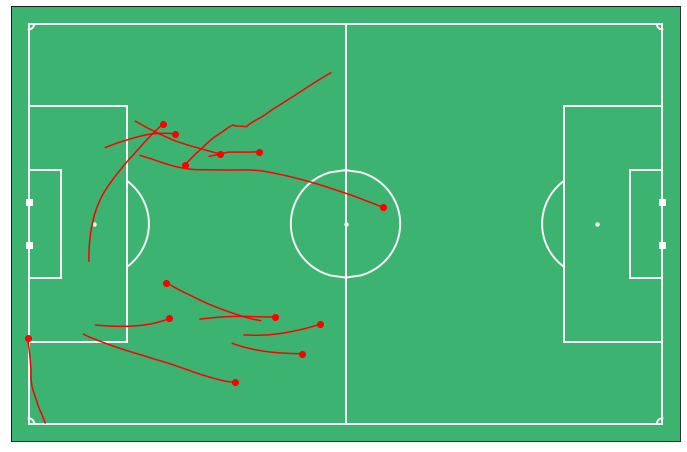

In [20]:
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro')
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')